# CIFAR10 with CNNs

Scores do modelo original:

 {'accuracy': 0.7136, 'balanced_accuracy': np.float64(0.7136000000000001), 'precision': 0.7141355730287995, 'recall': 0.7136, 'f1_score': 0.7133133029149751}

In [1]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [2]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

100%|██████████| 170M/170M [00:17<00:00, 9.55MB/s] 


Gera val_dataset como subset balanceado de train_val_dataset


In [4]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [5]:
def makeLoaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Visualizar imagens

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [7]:
# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

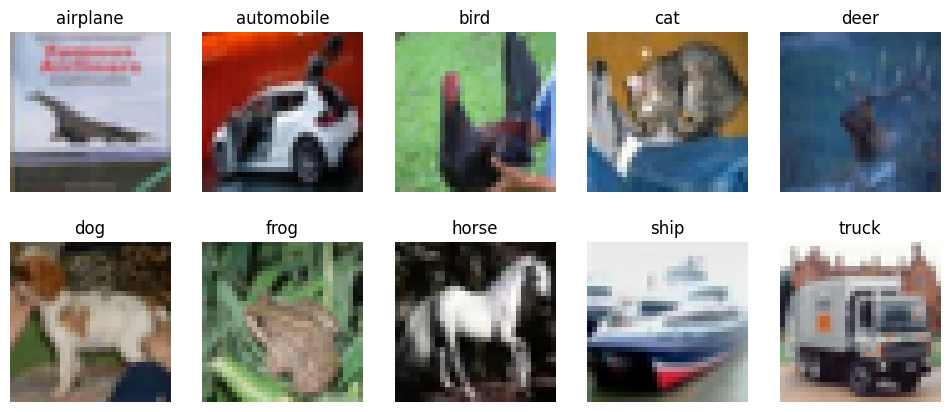

In [8]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [9]:
pooling_function = nn.MaxPool2d

In [13]:
class FlexibleCNN(nn.Module):
    """
    Uma classe de CNN flexível com entrada para imagens de 3 canais e 32x32 pixels.
    """
    def __init__(self, config):
        super(FlexibleCNN, self).__init__()
        self.config = config

        # Valores de entrada fixos
        initial_in_channels = 3
        img_height = 32
        img_width = 32

        # 1. Camadas de extração de características
        features_layers = []
        in_channels = initial_in_channels # Começa com o valor inicial

        for out_channels, k, s, p in self.config['conv_layers']:
            features_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=k,
                    stride=s,
                    padding=p
                )
            )
            features_layers.append(nn.ReLU())
            print(pooling_function)
            if self.config.get('pool_kernel_size'):
                features_layers.append(
                    pooling_function(
                        kernel_size=self.config['pool_kernel_size'],
                        stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                    )
                )
            in_channels = out_channels # Atualiza para a próxima camada do loop

        self.features = nn.Sequential(*features_layers)

        # 2. Calcular o tamanho da saída do extrator de features
        with torch.no_grad():
            dummy_input = torch.zeros(1, initial_in_channels, img_height, img_width)
            dummy_output = self.features(dummy_input)
            self.flattened_features_size = dummy_output.view(-1).shape[0]

        # 3. Construir o Classificador 
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            classifier_layers.append(nn.ReLU())
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        # O assert foi removido para simplificar, mas pode ser útil para debug
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Evaluation helper functions

In [14]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [15]:
def evaluate(net, loader, loss_function):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [16]:
#@title Evaluate model (accuracy, precision, recall, etc)

def makePredictions(net, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

In [17]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

## Train Loop

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experiment 1 - our baseline 

In [19]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [20]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [21]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.pooling.MaxPool2d'>


In [24]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:14<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 0.3240


  2%|▏         | 1/50 [00:21<17:16, 21.16s/it]

Epoch 1 completed. Train Loss: 0.2108 | Val Loss: 1.3947


  2%|▏         | 1/50 [00:35<17:16, 21.16s/it]

Epoch 2/50, Step 1000/1250, Loss: 0.0798


  4%|▍         | 2/50 [00:41<16:30, 20.63s/it]

Epoch 2 completed. Train Loss: 0.1551 | Val Loss: 1.5349


  4%|▍         | 2/50 [00:55<16:30, 20.63s/it]

Epoch 3/50, Step 1000/1250, Loss: 0.3012


  6%|▌         | 3/50 [01:00<15:46, 20.13s/it]

Epoch 3 completed. Train Loss: 0.1502 | Val Loss: 1.6134


  6%|▌         | 3/50 [01:13<15:46, 20.13s/it]

Epoch 4/50, Step 1000/1250, Loss: 0.1522


  8%|▊         | 4/50 [01:19<14:58, 19.54s/it]

Epoch 4 completed. Train Loss: 0.1201 | Val Loss: 1.7347


  8%|▊         | 4/50 [01:32<14:58, 19.54s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.0022


 10%|█         | 5/50 [01:38<14:21, 19.13s/it]

Epoch 5 completed. Train Loss: 0.1161 | Val Loss: 1.7210


 10%|█         | 5/50 [01:49<14:21, 19.13s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.3517


 10%|█         | 5/50 [01:55<17:17, 23.06s/it]

Epoch 6 completed. Train Loss: 0.1012 | Val Loss: 1.8118
Early stopping at epoch 6


## Experiment 1 results

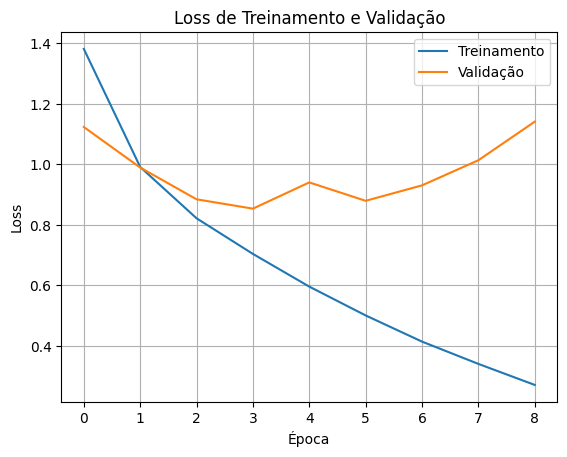

In [20]:
plotLoss(train_losses, val_losses)

In [21]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained.pth", weights_only=True))

<All keys matched successfully>

In [23]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


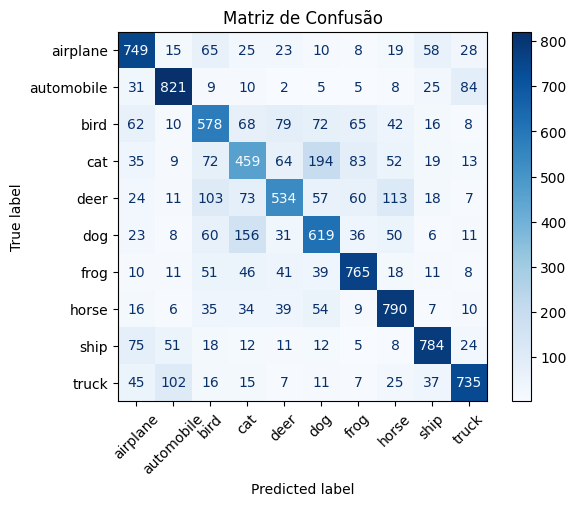

In [24]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2 - decrease learning rate

Diminuir o learning rate

In [15]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [16]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model2 = FlexibleCNN(config1)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [17]:
trained_CNN, train_losses, val_losses = train_model(model2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:12<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5811


  2%|▏         | 1/50 [00:17<14:33, 17.83s/it]

Epoch 1 completed. Train Loss: 1.7610 | Val Loss: 1.5436


  2%|▏         | 1/50 [00:29<14:33, 17.83s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.3359


  4%|▍         | 2/50 [00:34<13:49, 17.29s/it]

Epoch 2 completed. Train Loss: 1.4540 | Val Loss: 1.3899


  4%|▍         | 2/50 [00:45<13:49, 17.29s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2491


  6%|▌         | 3/50 [00:51<13:23, 17.09s/it]

Epoch 3 completed. Train Loss: 1.3465 | Val Loss: 1.3112


  6%|▌         | 3/50 [01:03<13:23, 17.09s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.4880


  8%|▊         | 4/50 [01:08<13:06, 17.09s/it]

Epoch 4 completed. Train Loss: 1.2668 | Val Loss: 1.2551


  8%|▊         | 4/50 [01:19<13:06, 17.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7146


 10%|█         | 5/50 [01:25<12:47, 17.05s/it]

Epoch 5 completed. Train Loss: 1.2023 | Val Loss: 1.1940


 10%|█         | 5/50 [01:37<12:47, 17.05s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.9474


 12%|█▏        | 6/50 [01:42<12:30, 17.05s/it]

Epoch 6 completed. Train Loss: 1.1465 | Val Loss: 1.1402


 12%|█▏        | 6/50 [01:54<12:30, 17.05s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.8789


 14%|█▍        | 7/50 [01:59<12:15, 17.10s/it]

Epoch 7 completed. Train Loss: 1.0930 | Val Loss: 1.1132


 14%|█▍        | 7/50 [02:11<12:15, 17.10s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.9707


 16%|█▌        | 8/50 [02:16<11:54, 17.01s/it]

Epoch 8 completed. Train Loss: 1.0452 | Val Loss: 1.0843


 16%|█▌        | 8/50 [02:28<11:54, 17.01s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.6057


 18%|█▊        | 9/50 [02:33<11:38, 17.03s/it]

Epoch 9 completed. Train Loss: 1.0034 | Val Loss: 1.0469


 18%|█▊        | 9/50 [02:45<11:38, 17.03s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.3411


 20%|██        | 10/50 [02:50<11:21, 17.04s/it]

Epoch 10 completed. Train Loss: 0.9646 | Val Loss: 1.0307


 20%|██        | 10/50 [03:02<11:21, 17.04s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9521


 22%|██▏       | 11/50 [03:07<11:02, 16.98s/it]

Epoch 11 completed. Train Loss: 0.9273 | Val Loss: 0.9976


 22%|██▏       | 11/50 [03:18<11:02, 16.98s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.6940


 24%|██▍       | 12/50 [03:24<10:44, 16.96s/it]

Epoch 12 completed. Train Loss: 0.8947 | Val Loss: 0.9962


 24%|██▍       | 12/50 [03:35<10:44, 16.96s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.7141


 26%|██▌       | 13/50 [03:41<10:26, 16.94s/it]

Epoch 13 completed. Train Loss: 0.8645 | Val Loss: 0.9651


 26%|██▌       | 13/50 [03:52<10:26, 16.94s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.6127


 28%|██▊       | 14/50 [03:58<10:10, 16.95s/it]

Epoch 14 completed. Train Loss: 0.8354 | Val Loss: 0.9561


 28%|██▊       | 14/50 [04:09<10:10, 16.95s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.7730


 30%|███       | 15/50 [04:15<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.8086 | Val Loss: 0.9339


 30%|███       | 15/50 [04:26<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.5296


 32%|███▏      | 16/50 [04:32<09:34, 16.89s/it]

Epoch 16 completed. Train Loss: 0.7838 | Val Loss: 0.9557


 32%|███▏      | 16/50 [04:43<09:34, 16.89s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.7410


 34%|███▍      | 17/50 [04:48<09:15, 16.85s/it]

Epoch 17 completed. Train Loss: 0.7591 | Val Loss: 0.9256


 34%|███▍      | 17/50 [05:00<09:15, 16.85s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6086


 36%|███▌      | 18/50 [05:05<08:59, 16.86s/it]

Epoch 18 completed. Train Loss: 0.7353 | Val Loss: 0.9160


 36%|███▌      | 18/50 [05:17<08:59, 16.86s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7741


 38%|███▊      | 19/50 [05:22<08:44, 16.90s/it]

Epoch 19 completed. Train Loss: 0.7118 | Val Loss: 0.9095


 38%|███▊      | 19/50 [05:34<08:44, 16.90s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.5819


 40%|████      | 20/50 [05:39<08:27, 16.93s/it]

Epoch 20 completed. Train Loss: 0.6885 | Val Loss: 0.9085


 40%|████      | 20/50 [05:50<08:27, 16.93s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.4198


 42%|████▏     | 21/50 [05:56<08:08, 16.84s/it]

Epoch 21 completed. Train Loss: 0.6658 | Val Loss: 0.9132


 42%|████▏     | 21/50 [06:07<08:08, 16.84s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7405


 44%|████▍     | 22/50 [06:13<07:51, 16.83s/it]

Epoch 22 completed. Train Loss: 0.6424 | Val Loss: 0.9077


 44%|████▍     | 22/50 [06:24<07:51, 16.83s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5145


 46%|████▌     | 23/50 [06:29<07:33, 16.78s/it]

Epoch 23 completed. Train Loss: 0.6228 | Val Loss: 0.9235


 46%|████▌     | 23/50 [06:41<07:33, 16.78s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.8067


 48%|████▊     | 24/50 [06:46<07:15, 16.73s/it]

Epoch 24 completed. Train Loss: 0.6031 | Val Loss: 0.9059


 48%|████▊     | 24/50 [06:57<07:15, 16.73s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.7158


 50%|█████     | 25/50 [07:03<06:57, 16.69s/it]

Epoch 25 completed. Train Loss: 0.5804 | Val Loss: 0.9079


 50%|█████     | 25/50 [07:14<06:57, 16.69s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5276


 52%|█████▏    | 26/50 [07:19<06:38, 16.61s/it]

Epoch 26 completed. Train Loss: 0.5591 | Val Loss: 0.9417


 52%|█████▏    | 26/50 [07:30<06:38, 16.61s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.4083


 54%|█████▍    | 27/50 [07:36<06:22, 16.63s/it]

Epoch 27 completed. Train Loss: 0.5400 | Val Loss: 0.9326


 54%|█████▍    | 27/50 [07:47<06:22, 16.63s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.5458


 56%|█████▌    | 28/50 [07:53<06:07, 16.71s/it]

Epoch 28 completed. Train Loss: 0.5194 | Val Loss: 0.9589


 56%|█████▌    | 28/50 [08:04<06:07, 16.71s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6419


 56%|█████▌    | 28/50 [08:10<06:25, 17.51s/it]

Epoch 29 completed. Train Loss: 0.4981 | Val Loss: 0.9436
Early stopping at epoch 29


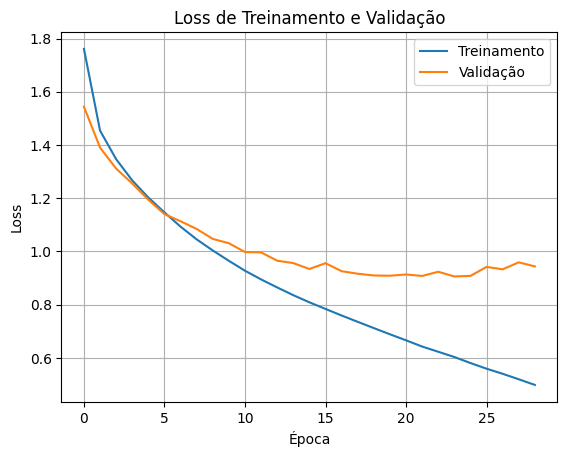

In [18]:
plotLoss(train_losses, val_losses)

In [19]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment 3 - add dropout

Adicionar dropout para diminuir o overfitting

In [21]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [26]:
config2 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model3 = FlexibleCNN(config2)

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [27]:
trained_CNN, train_losses, val_losses = train_model(model3,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:11<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5667


  2%|▏         | 1/50 [00:16<13:48, 16.90s/it]

Epoch 1 completed. Train Loss: 1.8439 | Val Loss: 1.5538


  2%|▏         | 1/50 [00:28<13:48, 16.90s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5844


  4%|▍         | 2/50 [00:34<13:56, 17.42s/it]

Epoch 2 completed. Train Loss: 1.5274 | Val Loss: 1.3970


  4%|▍         | 2/50 [00:46<13:56, 17.42s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2377


  6%|▌         | 3/50 [00:52<13:43, 17.52s/it]

Epoch 3 completed. Train Loss: 1.4188 | Val Loss: 1.3137


  6%|▌         | 3/50 [01:03<13:43, 17.52s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.6308


  8%|▊         | 4/50 [01:09<13:19, 17.39s/it]

Epoch 4 completed. Train Loss: 1.3390 | Val Loss: 1.2548


  8%|▊         | 4/50 [01:20<13:19, 17.39s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3819


 10%|█         | 5/50 [01:26<12:50, 17.13s/it]

Epoch 5 completed. Train Loss: 1.2822 | Val Loss: 1.2287


 10%|█         | 5/50 [01:37<12:50, 17.13s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.8351


 12%|█▏        | 6/50 [01:42<12:25, 16.94s/it]

Epoch 6 completed. Train Loss: 1.2266 | Val Loss: 1.1450


 12%|█▏        | 6/50 [01:53<12:25, 16.94s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.5058


 14%|█▍        | 7/50 [01:59<12:04, 16.85s/it]

Epoch 7 completed. Train Loss: 1.1772 | Val Loss: 1.1295


 14%|█▍        | 7/50 [02:10<12:04, 16.85s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.8592


 16%|█▌        | 8/50 [02:16<11:45, 16.79s/it]

Epoch 8 completed. Train Loss: 1.1342 | Val Loss: 1.0799


 16%|█▌        | 8/50 [02:27<11:45, 16.79s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.2255


 18%|█▊        | 9/50 [02:32<11:24, 16.70s/it]

Epoch 9 completed. Train Loss: 1.0939 | Val Loss: 1.0429


 18%|█▊        | 9/50 [02:43<11:24, 16.70s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.9510


 20%|██        | 10/50 [02:48<11:03, 16.60s/it]

Epoch 10 completed. Train Loss: 1.0574 | Val Loss: 1.0479


 20%|██        | 10/50 [02:59<11:03, 16.60s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.8078


 22%|██▏       | 11/50 [03:05<10:45, 16.54s/it]

Epoch 11 completed. Train Loss: 1.0225 | Val Loss: 1.0002


 22%|██▏       | 11/50 [03:16<10:45, 16.54s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.4551


 24%|██▍       | 12/50 [03:21<10:28, 16.54s/it]

Epoch 12 completed. Train Loss: 0.9875 | Val Loss: 0.9871


 24%|██▍       | 12/50 [03:32<10:28, 16.54s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.9081


 26%|██▌       | 13/50 [03:38<10:12, 16.55s/it]

Epoch 13 completed. Train Loss: 0.9626 | Val Loss: 0.9662


 26%|██▌       | 13/50 [03:50<10:12, 16.55s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.7623


 28%|██▊       | 14/50 [03:55<10:05, 16.81s/it]

Epoch 14 completed. Train Loss: 0.9323 | Val Loss: 0.9660


 28%|██▊       | 14/50 [04:07<10:05, 16.81s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0897


 30%|███       | 15/50 [04:13<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.9029 | Val Loss: 0.9334


 30%|███       | 15/50 [04:24<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.6132


 32%|███▏      | 16/50 [04:30<09:35, 16.94s/it]

Epoch 16 completed. Train Loss: 0.8810 | Val Loss: 0.9370


 32%|███▏      | 16/50 [04:41<09:35, 16.94s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.9251


 34%|███▍      | 17/50 [04:46<09:14, 16.81s/it]

Epoch 17 completed. Train Loss: 0.8574 | Val Loss: 0.9103


 34%|███▍      | 17/50 [04:57<09:14, 16.81s/it]

Epoch 18/50, Step 1000/1250, Loss: 1.1147


 36%|███▌      | 18/50 [05:03<08:55, 16.75s/it]

Epoch 18 completed. Train Loss: 0.8294 | Val Loss: 0.9036


 36%|███▌      | 18/50 [05:14<08:55, 16.75s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.8921


 38%|███▊      | 19/50 [05:19<08:37, 16.70s/it]

Epoch 19 completed. Train Loss: 0.8092 | Val Loss: 0.9028


 38%|███▊      | 19/50 [05:30<08:37, 16.70s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.7207


 40%|████      | 20/50 [05:36<08:18, 16.63s/it]

Epoch 20 completed. Train Loss: 0.7909 | Val Loss: 0.8880


 40%|████      | 20/50 [05:47<08:18, 16.63s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.7204


 42%|████▏     | 21/50 [05:52<07:59, 16.55s/it]

Epoch 21 completed. Train Loss: 0.7675 | Val Loss: 0.8917


 42%|████▏     | 21/50 [06:03<07:59, 16.55s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.8035


 44%|████▍     | 22/50 [06:08<07:40, 16.46s/it]

Epoch 22 completed. Train Loss: 0.7499 | Val Loss: 0.8733


 44%|████▍     | 22/50 [06:19<07:40, 16.46s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.7199


 46%|████▌     | 23/50 [06:25<07:24, 16.47s/it]

Epoch 23 completed. Train Loss: 0.7220 | Val Loss: 0.8768


 46%|████▌     | 23/50 [06:36<07:24, 16.47s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6686


 48%|████▊     | 24/50 [06:41<07:09, 16.53s/it]

Epoch 24 completed. Train Loss: 0.7071 | Val Loss: 0.8726


 48%|████▊     | 24/50 [06:52<07:09, 16.53s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.4286


 50%|█████     | 25/50 [06:58<06:52, 16.48s/it]

Epoch 25 completed. Train Loss: 0.6893 | Val Loss: 0.8862


 50%|█████     | 25/50 [07:09<06:52, 16.48s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.7701


 52%|█████▏    | 26/50 [07:14<06:33, 16.41s/it]

Epoch 26 completed. Train Loss: 0.6696 | Val Loss: 0.8701


 52%|█████▏    | 26/50 [07:25<06:33, 16.41s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.7747


 54%|█████▍    | 27/50 [07:30<06:16, 16.37s/it]

Epoch 27 completed. Train Loss: 0.6426 | Val Loss: 0.8682


 54%|█████▍    | 27/50 [07:41<06:16, 16.37s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.7360


 56%|█████▌    | 28/50 [07:47<06:01, 16.43s/it]

Epoch 28 completed. Train Loss: 0.6297 | Val Loss: 0.8665


 56%|█████▌    | 28/50 [07:58<06:01, 16.43s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6490


 58%|█████▊    | 29/50 [08:04<05:46, 16.50s/it]

Epoch 29 completed. Train Loss: 0.6093 | Val Loss: 0.8647


 58%|█████▊    | 29/50 [08:15<05:46, 16.50s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6459


 60%|██████    | 30/50 [08:20<05:29, 16.46s/it]

Epoch 30 completed. Train Loss: 0.5916 | Val Loss: 0.8741


 60%|██████    | 30/50 [08:31<05:29, 16.46s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.4459


 62%|██████▏   | 31/50 [08:36<05:11, 16.41s/it]

Epoch 31 completed. Train Loss: 0.5737 | Val Loss: 0.8678


 62%|██████▏   | 31/50 [08:47<05:11, 16.41s/it]

Epoch 32/50, Step 1000/1250, Loss: 0.6674


 64%|██████▍   | 32/50 [08:53<04:56, 16.48s/it]

Epoch 32 completed. Train Loss: 0.5502 | Val Loss: 0.8851


 64%|██████▍   | 32/50 [09:04<04:56, 16.48s/it]

Epoch 33/50, Step 1000/1250, Loss: 0.3232


 66%|██████▌   | 33/50 [09:10<04:42, 16.61s/it]

Epoch 33 completed. Train Loss: 0.5426 | Val Loss: 0.8834


 66%|██████▌   | 33/50 [09:21<04:42, 16.61s/it]

Epoch 34/50, Step 1000/1250, Loss: 0.2317


 66%|██████▌   | 33/50 [09:26<04:51, 17.17s/it]

Epoch 34 completed. Train Loss: 0.5203 | Val Loss: 0.9071
Early stopping at epoch 34


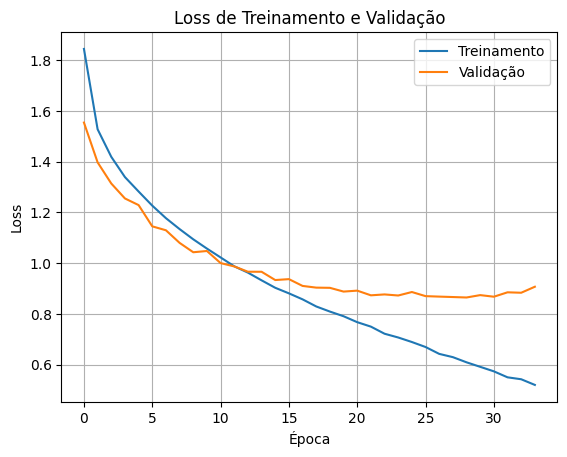

In [28]:
plotLoss(train_losses, val_losses)

In [29]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment 5 - Average Pooling

Change pooling function to Average Pooling

In [25]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5
pooling_function = nn.AvgPool2d

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [26]:
config_avg_pool = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model_avg_pool = FlexibleCNN(config_avg_pool)

optimizer = optim.Adam(model_avg_pool.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

<class 'torch.nn.modules.pooling.AvgPool2d'>
<class 'torch.nn.modules.pooling.AvgPool2d'>


In [27]:
trained_CNN, train_losses, val_losses = train_model(model_avg_pool,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:10<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.6755


  2%|▏         | 1/50 [00:15<12:51, 15.74s/it]

Epoch 1 completed. Train Loss: 1.7916 | Val Loss: 1.5929


  2%|▏         | 1/50 [00:35<12:51, 15.74s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.1528


  4%|▍         | 2/50 [00:48<20:26, 25.55s/it]

Epoch 2 completed. Train Loss: 1.5258 | Val Loss: 1.4882


  4%|▍         | 2/50 [01:13<20:26, 25.55s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.4497


  6%|▌         | 3/50 [01:18<21:53, 27.94s/it]

Epoch 3 completed. Train Loss: 1.4293 | Val Loss: 1.4093


  6%|▌         | 3/50 [01:30<21:53, 27.94s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.0744


  8%|▊         | 4/50 [01:35<17:57, 23.43s/it]

Epoch 4 completed. Train Loss: 1.3667 | Val Loss: 1.3594


  8%|▊         | 4/50 [01:46<17:57, 23.43s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3451


 10%|█         | 5/50 [01:52<15:47, 21.05s/it]

Epoch 5 completed. Train Loss: 1.3153 | Val Loss: 1.3188


 10%|█         | 5/50 [02:03<15:47, 21.05s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.4939


 12%|█▏        | 6/50 [02:09<14:26, 19.69s/it]

Epoch 6 completed. Train Loss: 1.2652 | Val Loss: 1.2758


 12%|█▏        | 6/50 [02:23<14:26, 19.69s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.1416


 14%|█▍        | 7/50 [02:30<14:33, 20.31s/it]

Epoch 7 completed. Train Loss: 1.2230 | Val Loss: 1.2414


 14%|█▍        | 7/50 [02:45<14:33, 20.31s/it]

Epoch 8/50, Step 1000/1250, Loss: 1.1411


 16%|█▌        | 8/50 [02:51<14:14, 20.36s/it]

Epoch 8 completed. Train Loss: 1.1810 | Val Loss: 1.2134


 16%|█▌        | 8/50 [03:08<14:14, 20.36s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.0962


 18%|█▊        | 9/50 [03:15<14:41, 21.50s/it]

Epoch 9 completed. Train Loss: 1.1443 | Val Loss: 1.1796


 18%|█▊        | 9/50 [03:29<14:41, 21.50s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.2508


 20%|██        | 10/50 [03:37<14:22, 21.57s/it]

Epoch 10 completed. Train Loss: 1.1091 | Val Loss: 1.1629


 20%|██        | 10/50 [03:52<14:22, 21.57s/it]

Epoch 11/50, Step 1000/1250, Loss: 1.0623


 22%|██▏       | 11/50 [03:59<14:06, 21.70s/it]

Epoch 11 completed. Train Loss: 1.0756 | Val Loss: 1.1374


 22%|██▏       | 11/50 [04:11<14:06, 21.70s/it]

Epoch 12/50, Step 1000/1250, Loss: 1.3897


 24%|██▍       | 12/50 [04:17<13:12, 20.84s/it]

Epoch 12 completed. Train Loss: 1.0408 | Val Loss: 1.1253


 24%|██▍       | 12/50 [04:31<13:12, 20.84s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.8250


 26%|██▌       | 13/50 [04:38<12:49, 20.81s/it]

Epoch 13 completed. Train Loss: 1.0122 | Val Loss: 1.0971


 26%|██▌       | 13/50 [04:53<12:49, 20.81s/it]

Epoch 14/50, Step 1000/1250, Loss: 1.0141


 28%|██▊       | 14/50 [05:00<12:43, 21.20s/it]

Epoch 14 completed. Train Loss: 0.9828 | Val Loss: 1.0834


 28%|██▊       | 14/50 [05:17<12:43, 21.20s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0619


 30%|███       | 15/50 [05:25<13:02, 22.35s/it]

Epoch 15 completed. Train Loss: 0.9558 | Val Loss: 1.0853


 30%|███       | 15/50 [05:41<13:02, 22.35s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.7942


 32%|███▏      | 16/50 [05:48<12:45, 22.50s/it]

Epoch 16 completed. Train Loss: 0.9297 | Val Loss: 1.0622


 32%|███▏      | 16/50 [06:01<12:45, 22.50s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.8158


 34%|███▍      | 17/50 [06:07<11:48, 21.47s/it]

Epoch 17 completed. Train Loss: 0.9024 | Val Loss: 1.0557


 34%|███▍      | 17/50 [06:19<11:48, 21.47s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.5095


 36%|███▌      | 18/50 [06:25<10:53, 20.41s/it]

Epoch 18 completed. Train Loss: 0.8801 | Val Loss: 1.0372


 36%|███▌      | 18/50 [06:42<10:53, 20.41s/it]

Epoch 19/50, Step 1000/1250, Loss: 1.0324


 38%|███▊      | 19/50 [06:48<10:59, 21.27s/it]

Epoch 19 completed. Train Loss: 0.8534 | Val Loss: 1.0344


 38%|███▊      | 19/50 [07:03<10:59, 21.27s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.7178


 40%|████      | 20/50 [07:08<10:24, 20.82s/it]

Epoch 20 completed. Train Loss: 0.8321 | Val Loss: 1.0165


 40%|████      | 20/50 [07:23<10:24, 20.82s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.9051


 42%|████▏     | 21/50 [07:30<10:16, 21.24s/it]

Epoch 21 completed. Train Loss: 0.8103 | Val Loss: 1.0156


 42%|████▏     | 21/50 [07:46<10:16, 21.24s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7537


 44%|████▍     | 22/50 [07:52<09:57, 21.34s/it]

Epoch 22 completed. Train Loss: 0.7864 | Val Loss: 1.0298


 44%|████▍     | 22/50 [08:07<09:57, 21.34s/it]

Epoch 23/50, Step 1000/1250, Loss: 1.1513


 46%|████▌     | 23/50 [08:13<09:34, 21.28s/it]

Epoch 23 completed. Train Loss: 0.7667 | Val Loss: 1.0409


 46%|████▌     | 23/50 [08:29<09:34, 21.28s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6862


 48%|████▊     | 24/50 [08:37<09:31, 21.98s/it]

Epoch 24 completed. Train Loss: 0.7446 | Val Loss: 1.0115


 48%|████▊     | 24/50 [08:52<09:31, 21.98s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.4737


 50%|█████     | 25/50 [08:59<09:13, 22.13s/it]

Epoch 25 completed. Train Loss: 0.7219 | Val Loss: 1.0168


 50%|█████     | 25/50 [09:13<09:13, 22.13s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.8972


 52%|█████▏    | 26/50 [09:19<08:35, 21.48s/it]

Epoch 26 completed. Train Loss: 0.7023 | Val Loss: 1.0258


 52%|█████▏    | 26/50 [09:35<08:35, 21.48s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.5247


 54%|█████▍    | 27/50 [09:42<08:22, 21.83s/it]

Epoch 27 completed. Train Loss: 0.6803 | Val Loss: 1.0050


 54%|█████▍    | 27/50 [09:55<08:22, 21.83s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.7767


 56%|█████▌    | 28/50 [10:01<07:43, 21.07s/it]

Epoch 28 completed. Train Loss: 0.6613 | Val Loss: 1.0276


 56%|█████▌    | 28/50 [10:15<07:43, 21.07s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.7231


 58%|█████▊    | 29/50 [10:22<07:20, 20.97s/it]

Epoch 29 completed. Train Loss: 0.6376 | Val Loss: 1.0184


 58%|█████▊    | 29/50 [10:37<07:20, 20.97s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6644


 60%|██████    | 30/50 [10:46<07:18, 21.90s/it]

Epoch 30 completed. Train Loss: 0.6190 | Val Loss: 1.0388


 60%|██████    | 30/50 [11:03<07:18, 21.90s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.4881


 62%|██████▏   | 31/50 [11:10<07:06, 22.43s/it]

Epoch 31 completed. Train Loss: 0.5996 | Val Loss: 1.0158


 62%|██████▏   | 31/50 [11:25<07:06, 22.43s/it]

Epoch 32/50, Step 1000/1250, Loss: 0.4846


 62%|██████▏   | 31/50 [11:32<07:04, 22.35s/it]

Epoch 32 completed. Train Loss: 0.5799 | Val Loss: 1.0559
Early stopping at epoch 32


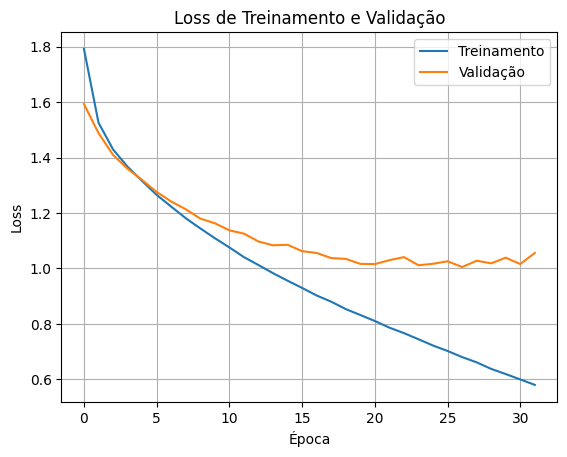

In [28]:
plotLoss(train_losses, val_losses)

In [29]:
labels, predictions = makePredictions(model_avg_pool, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6541, 'balanced_accuracy': np.float64(0.6541), 'precision': 0.6623958908918549, 'recall': 0.6541, 'f1_score': 0.6560778537354303}


In [30]:
pooling_function = nn.MaxPool2d

## Experiment 6 - Padding 'same'

In [31]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config_padding_same = {
    'conv_layers': [
        (32, 3, 1, 'same'),
        (64, 3, 1, 'same')
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model_padding_same = FlexibleCNN(config_padding_same)

optimizer = optim.Adam(model_padding_same.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.pooling.MaxPool2d'>


In [ ]:
trained_CNN, train_losses, val_losses = train_model(model_padding_same,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:12<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.6071


  2%|▏         | 1/50 [00:18<14:54, 18.25s/it]

Epoch 1 completed. Train Loss: 1.7725 | Val Loss: 1.5379


  2%|▏         | 1/50 [00:29<14:54, 18.25s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.1457


  4%|▍         | 2/50 [00:35<14:01, 17.53s/it]

Epoch 2 completed. Train Loss: 1.4535 | Val Loss: 1.3799


  4%|▍         | 2/50 [00:46<14:01, 17.53s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.1851


  6%|▌         | 3/50 [00:51<13:25, 17.15s/it]

Epoch 3 completed. Train Loss: 1.3411 | Val Loss: 1.3260


  6%|▌         | 3/50 [01:04<13:25, 17.15s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.1730


  8%|▊         | 4/50 [01:10<13:37, 17.77s/it]

Epoch 4 completed. Train Loss: 1.2594 | Val Loss: 1.2643


  8%|▊         | 4/50 [01:26<13:37, 17.77s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3918


 10%|█         | 5/50 [01:33<14:37, 19.49s/it]

Epoch 5 completed. Train Loss: 1.1915 | Val Loss: 1.1994


 10%|█         | 5/50 [01:46<14:37, 19.49s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.2297


 12%|█▏        | 6/50 [01:52<14:11, 19.35s/it]

Epoch 6 completed. Train Loss: 1.1295 | Val Loss: 1.1545


 12%|█▏        | 6/50 [02:05<14:11, 19.35s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.2890


 14%|█▍        | 7/50 [02:10<13:36, 19.00s/it]

Epoch 7 completed. Train Loss: 1.0762 | Val Loss: 1.1095


 14%|█▍        | 7/50 [02:22<13:36, 19.00s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.9865


 16%|█▌        | 8/50 [02:28<13:09, 18.80s/it]

Epoch 8 completed. Train Loss: 1.0313 | Val Loss: 1.0774


 16%|█▌        | 8/50 [02:41<13:09, 18.80s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.3819


 18%|█▊        | 9/50 [02:48<12:53, 18.88s/it]

Epoch 9 completed. Train Loss: 0.9883 | Val Loss: 1.0397


 18%|█▊        | 9/50 [03:00<12:53, 18.88s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.8690


 20%|██        | 10/50 [03:06<12:27, 18.69s/it]

Epoch 10 completed. Train Loss: 0.9504 | Val Loss: 1.0422


 20%|██        | 10/50 [03:18<12:27, 18.69s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.5160


 22%|██▏       | 11/50 [03:24<11:57, 18.41s/it]

Epoch 11 completed. Train Loss: 0.9147 | Val Loss: 1.0188


 22%|██▏       | 11/50 [03:36<11:57, 18.41s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.7645


 24%|██▍       | 12/50 [03:42<11:37, 18.36s/it]

Epoch 12 completed. Train Loss: 0.8820 | Val Loss: 0.9859


 24%|██▍       | 12/50 [03:54<11:37, 18.36s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.9640


 26%|██▌       | 13/50 [03:59<11:11, 18.15s/it]

Epoch 13 completed. Train Loss: 0.8510 | Val Loss: 0.9762


 26%|██▌       | 13/50 [04:13<11:11, 18.15s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.8447


 28%|██▊       | 14/50 [04:19<11:13, 18.70s/it]

Epoch 14 completed. Train Loss: 0.8209 | Val Loss: 0.9420


 28%|██▊       | 14/50 [04:31<11:13, 18.70s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.7700


 30%|███       | 15/50 [04:36<10:34, 18.13s/it]

Epoch 15 completed. Train Loss: 0.7941 | Val Loss: 0.9369


 30%|███       | 15/50 [04:48<10:34, 18.13s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.7095


 32%|███▏      | 16/50 [04:53<10:00, 17.65s/it]

Epoch 16 completed. Train Loss: 0.7697 | Val Loss: 0.9336


 32%|███▏      | 16/50 [05:05<10:00, 17.65s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.5444


 34%|███▍      | 17/50 [05:14<10:13, 18.60s/it]

Epoch 17 completed. Train Loss: 0.7451 | Val Loss: 0.9231


 34%|███▍      | 17/50 [05:34<10:13, 18.60s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6944


 36%|███▌      | 18/50 [05:44<11:47, 22.11s/it]

Epoch 18 completed. Train Loss: 0.7200 | Val Loss: 0.9697


 36%|███▌      | 18/50 [06:05<11:47, 22.11s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.6301


 38%|███▊      | 19/50 [06:15<12:47, 24.75s/it]

Epoch 19 completed. Train Loss: 0.6977 | Val Loss: 0.9181


 38%|███▊      | 19/50 [06:36<12:47, 24.75s/it]

Epoch 20/50, Step 1000/1250, Loss: 1.0890


 40%|████      | 20/50 [06:45<13:12, 26.41s/it]

Epoch 20 completed. Train Loss: 0.6703 | Val Loss: 0.9371


 40%|████      | 20/50 [07:05<13:12, 26.41s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.8970


 42%|████▏     | 21/50 [07:14<13:10, 27.26s/it]

Epoch 21 completed. Train Loss: 0.6491 | Val Loss: 0.9185


 42%|████▏     | 21/50 [07:35<13:10, 27.26s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7208


 44%|████▍     | 22/50 [07:45<13:08, 28.14s/it]

Epoch 22 completed. Train Loss: 0.6245 | Val Loss: 0.9206


 44%|████▍     | 22/50 [08:06<13:08, 28.14s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.4795


 46%|████▌     | 23/50 [08:16<13:06, 29.13s/it]

Epoch 23 completed. Train Loss: 0.6016 | Val Loss: 0.9092


 46%|████▌     | 23/50 [08:37<13:06, 29.13s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6199


 48%|████▊     | 24/50 [08:46<12:41, 29.30s/it]

Epoch 24 completed. Train Loss: 0.5781 | Val Loss: 0.9019


 48%|████▊     | 24/50 [09:06<12:41, 29.30s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.5430


 50%|█████     | 25/50 [09:16<12:17, 29.51s/it]

Epoch 25 completed. Train Loss: 0.5563 | Val Loss: 0.9243


 50%|█████     | 25/50 [09:37<12:17, 29.51s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5190


 52%|█████▏    | 26/50 [09:47<12:00, 30.00s/it]

Epoch 26 completed. Train Loss: 0.5325 | Val Loss: 0.9290


 52%|█████▏    | 26/50 [10:08<12:00, 30.00s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.3229


 54%|█████▍    | 27/50 [10:18<11:36, 30.30s/it]

Epoch 27 completed. Train Loss: 0.5126 | Val Loss: 0.9490


 54%|█████▍    | 27/50 [10:39<11:36, 30.30s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.3643


 56%|█████▌    | 28/50 [10:49<11:10, 30.49s/it]

Epoch 28 completed. Train Loss: 0.4883 | Val Loss: 0.9474


 56%|█████▌    | 28/50 [11:09<11:10, 30.49s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.5007


 56%|█████▌    | 28/50 [11:18<08:53, 24.23s/it]

Epoch 29 completed. Train Loss: 0.4702 | Val Loss: 0.9667
Early stopping at epoch 29


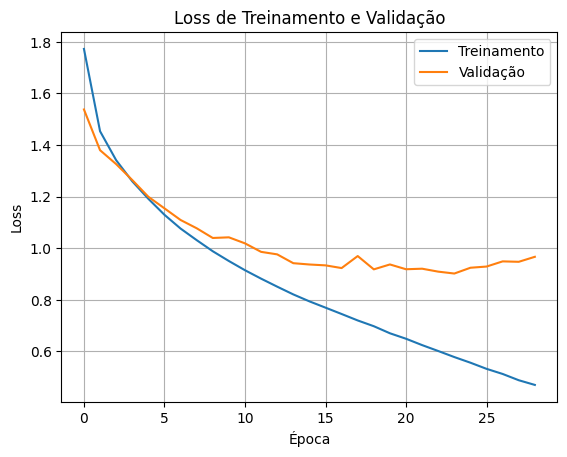

In [36]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model_padding_same, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6948, 'balanced_accuracy': np.float64(0.6948000000000001), 'precision': 0.6983279127228046, 'recall': 0.6948, 'f1_score': 0.6941744230180852}


## Experiment 7 - padding "valid"

In [38]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [39]:
config_padding_valid = {
    'conv_layers': [
        (32, 3, 1, 'valid'),
        (64, 3, 1, 'valid')
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model_padding_valid = FlexibleCNN(config_padding_valid)

optimizer = optim.Adam(model_padding_valid.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.pooling.MaxPool2d'>


In [40]:
trained_CNN, train_losses, val_losses = train_model(model_padding_valid,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:16<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.7627


  2%|▏         | 1/50 [00:24<20:14, 24.79s/it]

Epoch 1 completed. Train Loss: 1.8179 | Val Loss: 1.5834


  2%|▏         | 1/50 [00:41<20:14, 24.79s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.4442


  4%|▍         | 2/50 [00:49<19:34, 24.47s/it]

Epoch 2 completed. Train Loss: 1.4933 | Val Loss: 1.4306


  4%|▍         | 2/50 [01:07<19:34, 24.47s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.5281


  6%|▌         | 3/50 [01:18<20:54, 26.70s/it]

Epoch 3 completed. Train Loss: 1.3774 | Val Loss: 1.3621


  6%|▌         | 3/50 [01:43<20:54, 26.70s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.2196


  8%|▊         | 4/50 [01:53<23:04, 30.09s/it]

Epoch 4 completed. Train Loss: 1.2977 | Val Loss: 1.2763


  8%|▊         | 4/50 [02:17<23:04, 30.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.2000


 10%|█         | 5/50 [02:28<23:53, 31.86s/it]

Epoch 5 completed. Train Loss: 1.2351 | Val Loss: 1.2350


 10%|█         | 5/50 [02:45<23:53, 31.86s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.9770


 12%|█▏        | 6/50 [02:52<21:26, 29.24s/it]

Epoch 6 completed. Train Loss: 1.1824 | Val Loss: 1.2211


 12%|█▏        | 6/50 [03:08<21:26, 29.24s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.0515


 14%|█▍        | 7/50 [03:16<19:33, 27.29s/it]

Epoch 7 completed. Train Loss: 1.1375 | Val Loss: 1.1516


 14%|█▍        | 7/50 [03:32<19:33, 27.29s/it]

Epoch 8/50, Step 1000/1250, Loss: 1.3713


 16%|█▌        | 8/50 [03:39<18:17, 26.12s/it]

Epoch 8 completed. Train Loss: 1.0987 | Val Loss: 1.1301


 16%|█▌        | 8/50 [03:56<18:17, 26.12s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.4228


 18%|█▊        | 9/50 [04:04<17:29, 25.59s/it]

Epoch 9 completed. Train Loss: 1.0638 | Val Loss: 1.1283


 18%|█▊        | 9/50 [04:19<17:29, 25.59s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.8183


 20%|██        | 10/50 [04:27<16:34, 24.86s/it]

Epoch 10 completed. Train Loss: 1.0313 | Val Loss: 1.1123


 20%|██        | 10/50 [04:42<16:34, 24.86s/it]

Epoch 11/50, Step 1000/1250, Loss: 1.0555


 22%|██▏       | 11/50 [04:49<15:39, 24.10s/it]

Epoch 11 completed. Train Loss: 1.0014 | Val Loss: 1.0528


 22%|██▏       | 11/50 [05:05<15:39, 24.10s/it]

Epoch 12/50, Step 1000/1250, Loss: 1.2210


 24%|██▍       | 12/50 [05:12<14:58, 23.64s/it]

Epoch 12 completed. Train Loss: 0.9731 | Val Loss: 1.0330


 24%|██▍       | 12/50 [05:28<14:58, 23.64s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.7938


 26%|██▌       | 13/50 [05:35<14:33, 23.61s/it]

Epoch 13 completed. Train Loss: 0.9475 | Val Loss: 1.0279


 26%|██▌       | 13/50 [05:53<14:33, 23.61s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.8212


 28%|██▊       | 14/50 [06:00<14:24, 24.03s/it]

Epoch 14 completed. Train Loss: 0.9224 | Val Loss: 1.0512


 28%|██▊       | 14/50 [06:17<14:24, 24.03s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0318


 30%|███       | 15/50 [06:24<13:57, 23.94s/it]

Epoch 15 completed. Train Loss: 0.8975 | Val Loss: 1.0233


 30%|███       | 15/50 [06:39<13:57, 23.94s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.6925


 32%|███▏      | 16/50 [06:47<13:20, 23.53s/it]

Epoch 16 completed. Train Loss: 0.8742 | Val Loss: 1.0177


 32%|███▏      | 16/50 [07:02<13:20, 23.53s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.8121


 34%|███▍      | 17/50 [07:09<12:43, 23.15s/it]

Epoch 17 completed. Train Loss: 0.8544 | Val Loss: 0.9806


 34%|███▍      | 17/50 [07:24<12:43, 23.15s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6200


 36%|███▌      | 18/50 [07:32<12:21, 23.16s/it]

Epoch 18 completed. Train Loss: 0.8338 | Val Loss: 0.9922


 36%|███▌      | 18/50 [07:49<12:21, 23.16s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.8453


 38%|███▊      | 19/50 [07:57<12:09, 23.55s/it]

Epoch 19 completed. Train Loss: 0.8141 | Val Loss: 0.9888


 38%|███▊      | 19/50 [08:13<12:09, 23.55s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.5220


 40%|████      | 20/50 [08:21<11:49, 23.67s/it]

Epoch 20 completed. Train Loss: 0.7947 | Val Loss: 0.9619


 40%|████      | 20/50 [08:36<11:49, 23.67s/it]

Epoch 21/50, Step 1000/1250, Loss: 1.1518


 42%|████▏     | 21/50 [08:43<11:19, 23.44s/it]

Epoch 21 completed. Train Loss: 0.7749 | Val Loss: 0.9579


 42%|████▏     | 21/50 [08:59<11:19, 23.44s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7849


 44%|████▍     | 22/50 [09:06<10:48, 23.16s/it]

Epoch 22 completed. Train Loss: 0.7543 | Val Loss: 0.9774


 44%|████▍     | 22/50 [09:21<10:48, 23.16s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.6409


 46%|████▌     | 23/50 [09:29<10:21, 23.03s/it]

Epoch 23 completed. Train Loss: 0.7352 | Val Loss: 0.9727


 46%|████▌     | 23/50 [09:46<10:21, 23.03s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6083


 48%|████▊     | 24/50 [09:53<10:11, 23.50s/it]

Epoch 24 completed. Train Loss: 0.7161 | Val Loss: 0.9693


 48%|████▊     | 24/50 [10:09<10:11, 23.50s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.9455


 50%|█████     | 25/50 [10:17<09:45, 23.43s/it]

Epoch 25 completed. Train Loss: 0.6999 | Val Loss: 0.9527


 50%|█████     | 25/50 [10:32<09:45, 23.43s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5641


 52%|█████▏    | 26/50 [10:39<09:17, 23.23s/it]

Epoch 26 completed. Train Loss: 0.6838 | Val Loss: 0.9642


 52%|█████▏    | 26/50 [10:55<09:17, 23.23s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.6951


 54%|█████▍    | 27/50 [11:02<08:49, 23.01s/it]

Epoch 27 completed. Train Loss: 0.6641 | Val Loss: 0.9682


 54%|█████▍    | 27/50 [11:17<08:49, 23.01s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.5402


 56%|█████▌    | 28/50 [11:24<08:20, 22.75s/it]

Epoch 28 completed. Train Loss: 0.6489 | Val Loss: 0.9811


 56%|█████▌    | 28/50 [11:41<08:20, 22.75s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.4577


 58%|█████▊    | 29/50 [11:49<08:11, 23.40s/it]

Epoch 29 completed. Train Loss: 0.6307 | Val Loss: 0.9895


 58%|█████▊    | 29/50 [12:05<08:11, 23.40s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6174


 58%|█████▊    | 29/50 [12:13<08:50, 25.28s/it]

Epoch 30 completed. Train Loss: 0.6147 | Val Loss: 0.9815
Early stopping at epoch 30


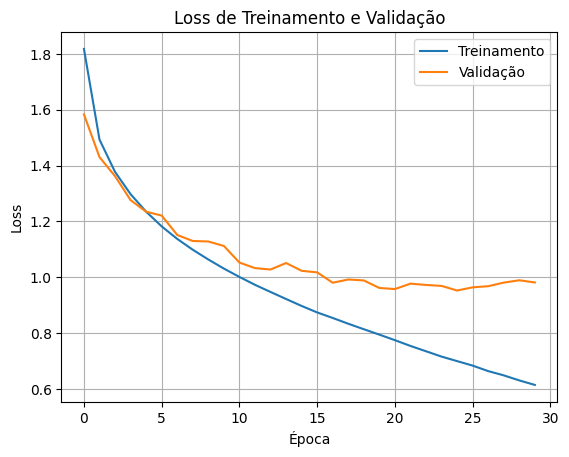

In [41]:
plotLoss(train_losses, val_losses)

In [42]:
labels, predictions = makePredictions(model_padding_valid, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6796, 'balanced_accuracy': np.float64(0.6796), 'precision': 0.6793032720353627, 'recall': 0.6796, 'f1_score': 0.6755857928977296}


## Mostrar exemplos classificados corretamente e incorretamente

In [25]:
# Função para desnormalizar e exibir em um subplot (sem plt.show())
def imshow_subplot(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy()
    # Desnormaliza a imagem
    img = img / 2 + 0.5
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    img = np.transpose(img, (1, 2, 0))
    
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

Encontradas 5 imagens corretas e 5 imagens incorretas.


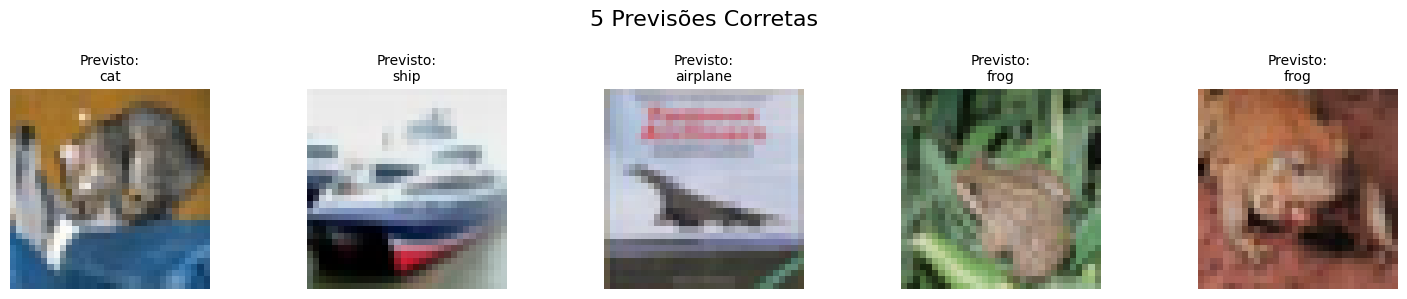

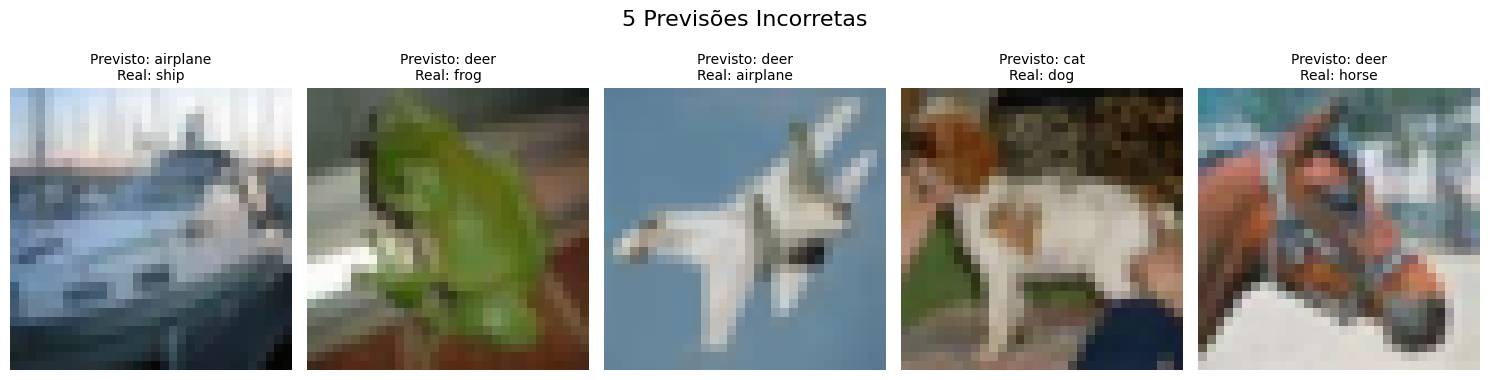

In [26]:
# Listas para armazenar os resultados
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []

model1.eval()

# Loop para encontrar as imagens
with torch.no_grad():
    # Itera sobre o loader de teste
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        _, preds = torch.max(outputs, 1)

        # Itera sobre o batch
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(preds[i].cpu())

            # Se a previsão está incorreta E ainda não temos 5
            elif preds[i] != labels[i] and len(incorrect_images) < 5:
                incorrect_images.append(images[i].cpu())
                incorrect_true_labels.append(labels[i].cpu())
                incorrect_pred_labels.append(preds[i].cpu())

            # Condição de parada: para quando ambas as listas estiverem cheias
            if len(correct_images) == 5 and len(incorrect_images) == 5:
                break
        
        # Para o loop principal também
        if len(correct_images) == 5 and len(incorrect_images) == 5:
            break

print(f"Encontradas {len(correct_images)} imagens corretas e {len(incorrect_images)} imagens incorretas.")


# Exibe as 5 previsões corretas
fig_correct, axes_correct = plt.subplots(1, 5, figsize=(15, 3))
fig_correct.suptitle("5 Previsões Corretas", fontsize=16)

for i, ax in enumerate(axes_correct):
    if i < len(correct_images):
        title = f"Previsto:\n{class_names[correct_labels[i].item()]}"
        imshow_subplot(ax, correct_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta para o super-título
plt.show()


# Exibe as 5 previsões incorretas
fig_incorrect, axes_incorrect = plt.subplots(1, 5, figsize=(15, 4)) # Um pouco mais de altura para o título duplo
fig_incorrect.suptitle("5 Previsões Incorretas", fontsize=16)

for i, ax in enumerate(axes_incorrect):
    if i < len(incorrect_images):
        title = f"Previsto: {class_names[incorrect_pred_labels[i].item()]}\nReal: {class_names[incorrect_true_labels[i].item()]}"
        imshow_subplot(ax, incorrect_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()